In [1]:
import os
os.add_dll_directory(r'C:\ProgramData\anaconda3\envs\MedicalAI\Lib\site-packages\openslide-win64-20231011\bin') 

<AddedDllDirectory('C:\\ProgramData\\anaconda3\\envs\\MedicalAI\\Lib\\site-packages\\openslide-win64-20231011\\bin')>

In [2]:
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from openslide import OpenSlide
import matplotlib.pyplot as plt

In [3]:
xml_file_path = r"G:\train_data\Breast1__he\slides\TCGA-A1-A0SM-01Z-00-DX1.xml"
slide_path = r"G:\train_data\Breast1__he\slides\TCGA-A1-A0SM-01Z-00-DX1.svs" 
mask_name = str(slide_path.split("\\")[-1])
slide = OpenSlide(slide_path)

195.0


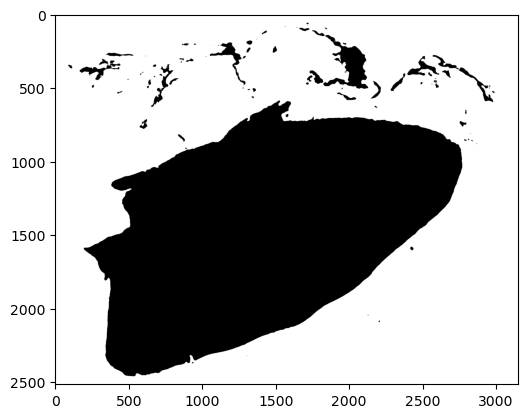

In [5]:
mask_level = 5 #?
downsample_factor = float(2 ** mask_level)

# create output directory
outdir = r'G:\train_data\Breast1__he\slidestissue_masks_{}'.format(mask_name)
if not os.path.exists(outdir):
    os.makedirs(outdir)

# get the best level to read whole slide at low resolution
im_read_level = slide.get_best_level_for_downsample(downsample_factor)
im_read_size = slide.level_dimensions[im_read_level]

# read the image
img = slide.read_region((0, 0), im_read_level, im_read_size)

# convert to a numpy array
img_arr = np.array(img)[:,:,:3]

# resize image to level6
im_size_level0 = slide.level_dimensions[0]
im_resized_size = (int(im_size_level0[0] / downsample_factor), int(im_size_level0[1] / downsample_factor))
img_arr = cv2.resize(img_arr, im_resized_size)

# convert image to gray-scale
gray_im = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)

# background - foreground seperation using OTSU thresholding
OTSU_thr, BW = cv2.threshold(gray_im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(OTSU_thr)

#apply_dilation
kernel = np.ones((3, 3), np.uint8)
img_dilation = cv2.bitwise_not(cv2.dilate(cv2.bitwise_not(BW), kernel, iterations=1))

# median filtering
BW_filtered = cv2.medianBlur(img_dilation, 19)

# invert image for further processing
des = cv2.bitwise_not(BW_filtered)

# hole filling
contour, hier = cv2.findContours(des, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    cv2.drawContours(des, [cnt], 0, 255, -1)
mask_img = cv2.bitwise_not(des)

# show the image
plt.imshow(mask_img, cmap='gray')